In [42]:
import logging
import os
import random
from collections import Counter

import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

import pollock
from pollock.models.model import PollockDataset, PollockModel, load_from_directory
import pollock.models.analysis as pollock_analysis

In [2]:
%load_ext autoreload

In [34]:
%autoreload 2

## load in expression table and labels

In [4]:
%%time
expression_df = pd.read_csv(
    '/home/estorrs/data/single_cell_classification/Intra-dataset/AMB/Filtered_mouse_allen_brain_data.csv',
    sep=',')
expression_df

,Unnamed: 0,0610005C13Rik,0610006L08Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010B08Rik,0610010F05Rik,...,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,n-R5s136
0,F1S4_160108_001_A01,0,0,79,145,1,46,123,0,0,...,0,0,0,78,0,36,1,0,190,0
1,F1S4_160108_001_B01,0,0,123,178,26,23,2,0,337,...,0,0,0,69,0,78,29,0,179,0
2,F1S4_160108_001_C01,0,0,89,69,0,13,29,0,112,...,0,0,2,273,38,110,81,0,178,0
3,F1S4_160108_001_D01,0,0,115,0,0,0,50,0,35,...,0,0,0,151,165,67,30,0,110,0
4,F1S4_160108_001_E01,0,0,402,208,0,42,0,0,0,...,20,0,1,99,50,83,69,0,335,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12827,FYS4_171004_103_H01,0,0,45,82,0,10,0,0,23,...,0,0,0,115,0,25,0,0,143,0
12828,FYS4_171004_104_A01,0,0,88,79,0,0,1,0,95,...,0,17,0,92,0,1,26,0,94,0
12829,FYS4_171004_104_B01,0,0,81,105,0,0,78,0,104,...,0,10,0,77,7,62,0,0,147,0
12830,FYS4_171004_104_C01,0,0,187,52,0,8,4,0,8,...,0,24,0,54,67,0,70,0,133,0


In [9]:
expression_df = expression_df.set_index('Unnamed: 0')
expression_df

,0610005C13Rik,0610006L08Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010B08Rik,0610010F05Rik,0610010K14Rik,...,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,n-R5s136
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
F1S4_160108_001_A01,0,0,79,145,1,46,123,0,0,33,...,0,0,0,78,0,36,1,0,190,0
F1S4_160108_001_B01,0,0,123,178,26,23,2,0,337,318,...,0,0,0,69,0,78,29,0,179,0
F1S4_160108_001_C01,0,0,89,69,0,13,29,0,112,76,...,0,0,2,273,38,110,81,0,178,0
F1S4_160108_001_D01,0,0,115,0,0,0,50,0,35,18,...,0,0,0,151,165,67,30,0,110,0
F1S4_160108_001_E01,0,0,402,208,0,42,0,0,0,42,...,20,0,1,99,50,83,69,0,335,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FYS4_171004_103_H01,0,0,45,82,0,10,0,0,23,64,...,0,0,0,115,0,25,0,0,143,0
FYS4_171004_104_A01,0,0,88,79,0,0,1,0,95,52,...,0,17,0,92,0,1,26,0,94,0
FYS4_171004_104_B01,0,0,81,105,0,0,78,0,104,100,...,0,10,0,77,7,62,0,0,147,0


In [5]:
label_df = pd.read_csv(
    '/home/estorrs/data/single_cell_classification/Intra-dataset/AMB/Labels.csv',
    sep=','
    )
label_df

,Class,Subclass,cluster
0,GABAergic,Vip,Vip Arhgap36 Hmcn1
1,GABAergic,Lamp5,Lamp5 Lsp1
2,GABAergic,Lamp5,Lamp5 Lsp1
3,GABAergic,Vip,Vip Crispld2 Htr2c
4,GABAergic,Lamp5,Lamp5 Plch2 Dock5
...,...,...,...
12827,Glutamatergic,L5 PT,L5 PT VISp Chrna6
12828,GABAergic,Sncg,Sncg Gpr50
12829,GABAergic,Pvalb,Pvalb Gpr149 Islr
12830,Glutamatergic,L5 PT,L5 PT VISp C1ql2 Cdh13


In [22]:
adata = anndata.AnnData(X=expression_df.values, obs=label_df)
adata.obs.index = expression_df.index
adata.var.index = expression_df.columns
adata

Transforming to str index.


AnnData object with n_obs × n_vars = 12832 × 42625 
    obs: 'Class', 'Subclass', 'cluster'

In [23]:
## ranodom subset for testing
idxs = np.asarray(random.sample(range(adata.shape[0]), 2000))
adata = adata[idxs, :]
adata

View of AnnData object with n_obs × n_vars = 2000 × 42625 
    obs: 'Class', 'Subclass', 'cluster'

In [24]:
adata.obs

,Class,Subclass,cluster
Unnamed: 0,,,
F2S4_170914_001_B01,Glutamatergic,L6 IT,L6 IT VISp Car3
F2S4_160120_021_B01,Glutamatergic,L6 CT,L6 CT VISp Krt80 Sla
F1S4_160108_005_B01,GABAergic,Lamp5,Lamp5 Plch2 Dock5
F2S4_160419_016_H01,GABAergic,Pvalb,Pvalb Gabrg1
F2S4_160317_010_D01,Glutamatergic,NP,L5 NP VISp Trhr Met
...,...,...,...
F2S4_170203_007_H01,Glutamatergic,L6 IT,L6 IT VISp Penk Col27a1
F2S4_170420_011_G01,GABAergic,Lamp5,Lamp5 Lhx6
F2S4_160504_006_G01,GABAergic,Lamp5,Lamp5 Plch2 Dock5


In [25]:
adata.var

""
0610005C13Rik
0610006L08Rik
0610007P14Rik
0610009B22Rik
0610009E02Rik
...
Zzef1
Zzz3
a
l7Rn6


In [26]:
adata.X

ArrayView([[  0.,   0., 163., ...,   0., 150.,   0.],
           [  0.,   0.,  50., ...,   0., 343.,   0.],
           [  0.,   0., 313., ...,   0., 293.,   0.],
           ...,
           [  0.,   0., 346., ...,   0., 178.,   0.],
           [  0.,   0., 108., ...,   0., 154.,   0.],
           [  0.,   0., 135., ...,   0., 215.,   0.]], dtype=float32)

In [27]:
adata.X.shape

(2000, 42625)

In [29]:
sc.tl.rank_genes_groups(adata, 'Class', method='t-test', n_genes=100)

## train pollock model

In [36]:
%%time

pollock_dataset = PollockDataset(adata, cell_type_key='Class', dataset_type='training',
                                image_root_dir='/home/estorrs/pollock/models/scratch/test_amb',
                                n_per_cell_type=500, max_val_per_cell_type=500)

2020-02-10 15:07:32 INFO     creating image templates
2020-02-10 15:07:34 INFO     writing training images
2020-02-10 15:07:34 INFO     writing images
2020-02-10 15:07:34 INFO     0 cell images written


0 cell images written


2020-02-10 15:08:14 INFO     1000000 cell images written


1000000 cell images written


2020-02-10 15:08:53 INFO     done writing images
2020-02-10 15:08:53 INFO     creating training dataset
2020-02-10 15:08:53 INFO     creating validation dataset


CPU times: user 1min 20s, sys: 573 ms, total: 1min 20s
Wall time: 1min 20s


array([[  1.,   1.,   1., ..., 201., 201., 201.],
       [  1.,   1.,   1., ..., 201., 201., 201.],
       [  1.,   1.,   1., ..., 201., 201., 201.],
       ...,
       [  1.,   1.,   1., ...,   1.,   1.,   1.],
       [  1.,   1.,   1., ...,   1.,   1.,   1.],
       [  1.,   1.,   1., ...,   1.,   1.,   1.]])

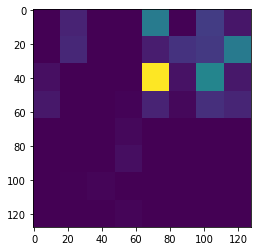

In [39]:
cell_id = adata.obs.index[0]
pollock_dataset.get_cell_image(cell_id)

In [40]:
pollock_dataset.cell_types

['GABAergic', 'Glutamatergic', 'Non-Neuronal']

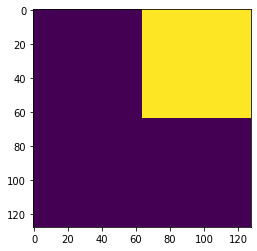

In [44]:
plt.imshow(pollock_dataset.cell_type_template=='Glutamatergic')

In [45]:
model = PollockModel(pollock_dataset.cell_types)

In [46]:
model.fit(pollock_dataset)

Train for 24 steps, validate for 7 steps
Epoch 1/10
24/24 [==============================] - 5s 217ms/step - loss: 0.1032 - accuracy: 0.9668 - val_loss: 2.9266e-04 - val_accuracy: 1.0000
Epoch 2/10
24/24 [==============================] - 4s 164ms/step - loss: 0.0021 - accuracy: 0.9993 - val_loss: 4.9605e-04 - val_accuracy: 1.0000
Epoch 3/10
24/24 [==============================] - 4s 155ms/step - loss: 0.0033 - accuracy: 0.9993 - val_loss: 1.0908e-05 - val_accuracy: 1.0000
Epoch 4/10
24/24 [==============================] - 4s 160ms/step - loss: 4.9441e-04 - accuracy: 0.9993 - val_loss: 6.7136e-06 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 4s 159ms/step - loss: 1.6949e-05 - accuracy: 1.0000 - val_loss: 1.5298e-05 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 4s 155ms/step - loss: 9.1147e-06 - accuracy: 1.0000 - val_loss: 5.7463e-06 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 4s 152ms/step - los

In [47]:
model.save(pollock_dataset, '/home/estorrs/pollock/models/abm_3class')

In [49]:
%%time
prediction_dataset, model = load_from_directory(adata, '/home/estorrs/pollock/models/abm_3class',
        image_root_dir = '/home/estorrs/pollock/models/scratch/test_amb_prediction')

2020-02-10 15:18:59 INFO     writing images
2020-02-10 15:18:59 INFO     0 cell images written
2020-02-10 15:19:38 INFO     1000 cell images written
2020-02-10 15:20:18 INFO     done writing images


Found 2000 images belonging to 1 classes.
CPU times: user 1min 19s, sys: 625 ms, total: 1min 20s
Wall time: 1min 20s


In [50]:
probs = model.predict(prediction_dataset)
probs.shape

(2000, 3)

In [51]:
predictions = np.argmax(probs, axis=1).flatten()
predicted_labels = [prediction_dataset.cell_types[i] for i in predictions]
len(predictions), predictions[:5]

(2000, array([0, 0, 0, 0, 0]))

array([0, 0, 0, ..., 1, 0, 1])

In [53]:
cell_type_to_index = {v:k for k, v in enumerate(prediction_dataset.cell_types)}
groundtruth = [cell_type_to_index[cell_type]
               for cell_type in adata[prediction_dataset.cell_ids, :].obs['Class']]
len(groundtruth), groundtruth[:5]

(2000, [0, 0, 0, 0, 0])

In [60]:
predictions[:20], groundtruth[:20]

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]),
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

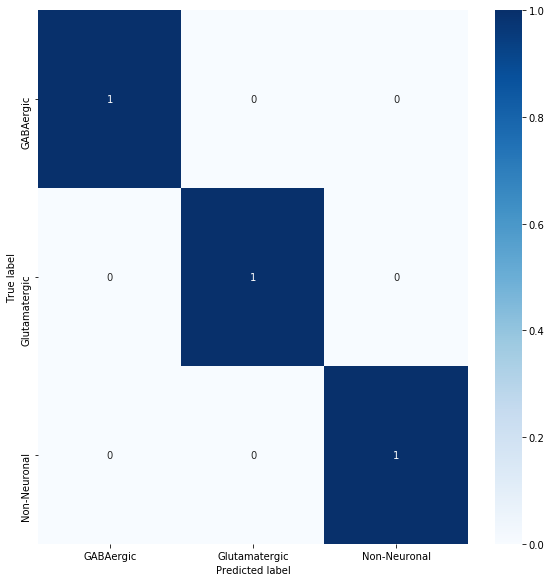

In [54]:
c_df = pollock_analysis.get_confusion_matrix(predictions, groundtruth, prediction_dataset.cell_types)

In [55]:
embedding = pollock_analysis.umap_final_layer(prediction_dataset.prediction_ds, model.model)
embedding.shape

(2000, 2)

... storing 'predicted_cell_type' as categorical


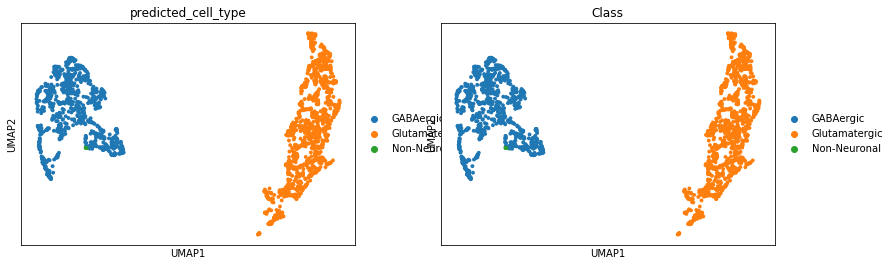

In [62]:
ordered_adata = adata[prediction_dataset.cell_ids, :]
ordered_adata.obsm['X_umap'] = embedding
ordered_adata.obs['predicted_cell_type'] = predicted_labels
sc.pl.umap(ordered_adata, color=['predicted_cell_type', 'Class'])